# Regression

In [1]:
%matplotlib inline
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/Users/aurianeblarre/miniconda3/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def normale(z, m, sigma):
    """ Loi normale, z sachant m et sigma"""
    return np.exp(-(z-m)**2/(2*sigma))/np.sqrt(2*np.pi*sigma)

In [5]:
class model:
    """Classe qui encapsule l'apprentissage"""
    
    def __init__(self, D, R):
        """Constructeur"""
        
        self.D = D #Nombre de variables explicatives
        self.R = R #Nombre d'annotateurs
     
    
    def chargeData(self, path, recentrage = True):
        """Fonction qui charge les données avec path le chemin du fichier CSV. 
        Par défault, on impose un recentrage des donnée"""
        
        data = pd.read_csv(path, delimiter = ";")
        self.trueLabel = np.array(data.ix[:,self.D])
        self.y = np.array(data.ix[:,self.D+1:]) #labels des annotateurs
        x = np.array(data.ix[:,0:self.D]) #variables explicatives
        if (recentrage):
            self.x = (x -np.mean(x,axis=0))/(np.std(x, axis=0))
        else:
            self.x = x
        self.N = self.y.shape[0] #Nombre de lignes
     
    
    def initw(self):
        """Initialisation de w"""
        
        w = []
        for i in range(0,self.D):
            w.append(1)
        self.w = np.array(w)
    
    
    def update_lambda(self):
        """Update du vecteur lambda (Rx1)"""
        lambd = []
        for j in range(0,self.R):
            tmp = 0
            for i in range(0,self.N):
                tmp += (self.y[i][j] - self.w.T.dot(self.x[i]))**2
            tmp = tmp/self.N
            lambd.append(1/tmp)
        self.lambd = np.array(lambd)
    
    
    def update_w(self):
        """Update du vecteur w (Nx1)"""
        
        w = 0
        tmp = 0
        for i in range(0,self.N):
            tmp += self.x[i].dot(self.x[i].T)
            tmp2 = 0
            for j in range(0,self.R):
                tmp2 += self.lambd[j]*self.y[i][j]
            w += self.x[i]*tmp2/(np.sum(self.lambd))
        self.w = self.w/tmp
       
    
   
    def logLikelihood(self):
        """Calcul de la log-vraissemblance."""
    
        #On calcule directement la log-vraissemblance.
        vraissemblance = 0
        for i in range(0,self.N):
            for j in range(0,self.R):
                vraissemblance += normale(self.y[i][j],self.w.T.dot(self.x[i]),1/self.lambd[j])
        return vraissemblance
    

   
    def score(self, seuil = 1/2):
        """Quel est le score d'apprentissage de notre modèle ?"""
        return np.mean(np.equal(self.trueLabel, np.array(self.w.dot(self.x.T))>seuil))
        
    def pred_labels(self):
        #Label que i va donner à j
        self.labels_predits = np.random.normal(self.w.T.dot(self.x[i]),1/self.lambd[j])
        
    
    
    def train(self, maxIter = 1000, epsilon = 0.01, graphe=True):
        """Fonction qui lance l'entrainement du modèle.
        La variable graphe sert à plotter la log-likelihood au fil des itérations.
        La log-likelihood devrait être croissante."""
        
        self.maxIter = maxIter
        
        self.initw()

        compteur = 0
        self.histLogLikelihood = []
        #while (np.linalg.norm(diff_w) > 0.001) : # Limite de convergence à decider
        while (compteur < maxIter):
            self.update_lambda()
            wOld = self.w
            self.update_w()
            wNew = self.w
            self.histLogLikelihood.append(self.logLikelihood())
            diffW = wOld - wNew
            if (np.linalg.norm(diffW) < epsilon) and (compteur>maxIter) :
                print("SEUIL DE CONVERGENCE SUR W ATTEINT")
                print ("ITERATION : ", compteur)
                print("Vraissemblance : ", self.logLikelihood())
                print("Norme de diff_w : ", np.linalg.norm(diffW))
                print("Lambda : ", self.lambd)
                break
            
            if (compteur % 100 == 0):
                print ("ITERATION : ", compteur)
                print("Vraissemblance : ", self.logLikelihood())
                print("Norme de diff_w : ", np.linalg.norm(diffW))
                print("Lambda : ", self.lambd)
            compteur = compteur + 1
        
        if graphe:
            plt.plot(self.histLogLikelihood)
            plt.title('Log-vraissemblance au fil des itérations')

ITERATION :  0
Vraissemblance :  349.959636858
Norme de diff_w :  3.31643622791
Lambda :  [ 0.02483044  0.01756045  0.02429476  0.02177924  0.02524118]
ITERATION :  100
Vraissemblance :  370.270609534
Norme de diff_w :  0.0
Lambda :  [ 0.03758113  0.02290392  0.03557637  0.03072701  0.03837343]
ITERATION :  200
Vraissemblance :  370.270609534
Norme de diff_w :  0.0
Lambda :  [ 0.03758113  0.02290392  0.03557637  0.03072701  0.03837343]
ITERATION :  300
Vraissemblance :  370.270609534
Norme de diff_w :  0.0
Lambda :  [ 0.03758113  0.02290392  0.03557637  0.03072701  0.03837343]
ITERATION :  400
Vraissemblance :  370.270609534
Norme de diff_w :  0.0
Lambda :  [ 0.03758113  0.02290392  0.03557637  0.03072701  0.03837343]


0.0

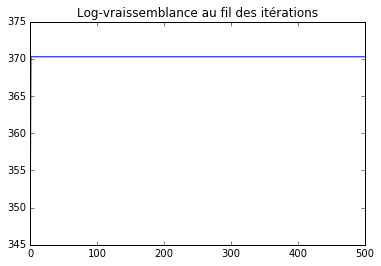

In [6]:
wine = model(11, 5)
wine.chargeData('Datasets/Wine/redwine_reg.csv')
wine.train(maxIter = 500, epsilon = 0.01, graphe = True)
wine.score()

array([ 2.68960437,  2.4048203 ,  2.14019138,  2.16425047,  2.17240274])